In [1]:
import os
import struct
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

In [2]:
ROOT = './'
File_Sources = "./ETL Character DataBase/"
Output_Dest = './ETL Character DataBase/Outputs/'

In [3]:
#for path, dirs, files in os.walk(ROOT):
#    print('-----')
#    print(path)
#    print(dirs)
#    print(files)

In [4]:
source_files = []
for path, _, files in os.walk('./ETL Character DataBase/File Sources/'):
    for f in files:
        if 'INFO' not in f:
            source_files.append(os.path.join(path,f))
print(len(source_files))
source_files

83


['./ETL Character DataBase/File Sources/ETL8G\\ETL8G_01',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_02',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_03',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_04',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_05',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_06',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_07',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_08',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_09',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_10',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_11',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_12',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_13',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_14',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_15',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_16',
 './ETL Character DataBase/File Sources/ETL8G\\ETL8G_17',
 './ETL Charac

In [5]:
# Create the JIS 0208 to unicode coversion table
JIS0208 = dict()
with open(ROOT+'Unicode Tables/JIS0208.TXT', 'r') as jf_src:
    line = jf_src.readline()
    while(line):
        if(not line[0]=='#'):
            elms = line.split('\t')
            jis = hex(int(elms[1], 16))
            uni = hex(int(elms[2], 16))
            JIS0208[jis] = uni
        line = jf_src.readline()
len(JIS0208)

6879

In [6]:
_9G_format = ">2H8sI4B4H2B34x8128s7x"

In [7]:
images = []
codes = []
code_count = dict()
total_samples = 0
#working_file = os.path.join(File_Sources+"File Sources\ETL9G/", "ETL9G_01")
load_start = time.time()
for working_file in source_files:
    with open(working_file, "rb") as f_src:
        data = f_src.read(8199)
        while data is not None and len(data)==8199:
            _data = struct.unpack(_9G_format, data)
            _hex = hex(_data[1])
            #print(str(_hex), str(_uni), chr(int(_uni, 16)))
                
            img = Image.frombytes('F', (128, 127), _data[14], 'bit', 4)
            img = img.convert('L')
            img = Image.eval(img, lambda x: 255 - x * 16)

            _uni = None
            if _hex in JIS0208:
                _uni = JIS0208[_hex]
            else:
                print('Code', str(_hex), 'not in conversion table.')
                img.save(os.path.join(File_Sources, 'Missing Codes', str(_hex)+'.png'))
                
            # This one leaves some weird smudging in the middle.
            # Unused
            #img = img.transform((128, 128), Image.EXTENT, (0,0,127,127))

            #img = img.resize((128,128), Image.Resampling.NEAREST)

            # Need to come up with a more generic approach.
            # Make a blank nxn canavas filled with white, fill in from src based on offsets.

            # Resize to 128 by 128, src is 127x128 np.array dim (128 Xs, 127 Ys)
            # This seems to give much better looking results overall.
            img_arr = np.array(img, dtype=np.uint8)
            new_row = np.zeros(shape=(1,128), dtype=np.uint8)+255
            img_arr = np.append(img_arr, new_row, axis=0)
            img = Image.fromarray(img_arr, mode="L")

            # Write to disk
            if not _uni in code_count:
                code_count[_uni] = 0
                if not os.path.isdir(os.path.join(Output_Dest, str(_uni))):
                    os.mkdir(os.path.join(Output_Dest, str(_uni)))
            code_count[_uni] += 1
            #img.save(os.path.join(Output_Dest, str(_uni), f"{code_count[_uni]:05d}"+'.png'))

            total_samples += 1

            #codes.append(_uni)
            #images.append(img)
            data = f_src.read(8199)
    print('Done with',working_file)
    if not f_src.closed:
        f_src.close()
#print(len(images))
print('Code Count:', len(code_count))
print('Total Samples:', total_samples)
print(f'Done after {(time.time()-load_start):.1f}s.')

Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_01
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_02
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_03
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_04
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_05
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_06
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_07
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_08
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_09
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_10
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_11
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_12
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_13
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_14
Done with ./ETL Character DataBase/File Sources/ETL8G\ETL8G_15
Done with ./ETL Character DataBase/File Sources/ETL8G\E

In [15]:
# https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
from mpl_toolkits.axes_grid1 import ImageGrid

In [19]:
sample_indicies = np.random.choice(len(images), 12)
sample_indicies

array([10621,  7681,  7058, 11195,  7151, 11485,  3690,  3662,  6612,
       11162,  8845,  2851])

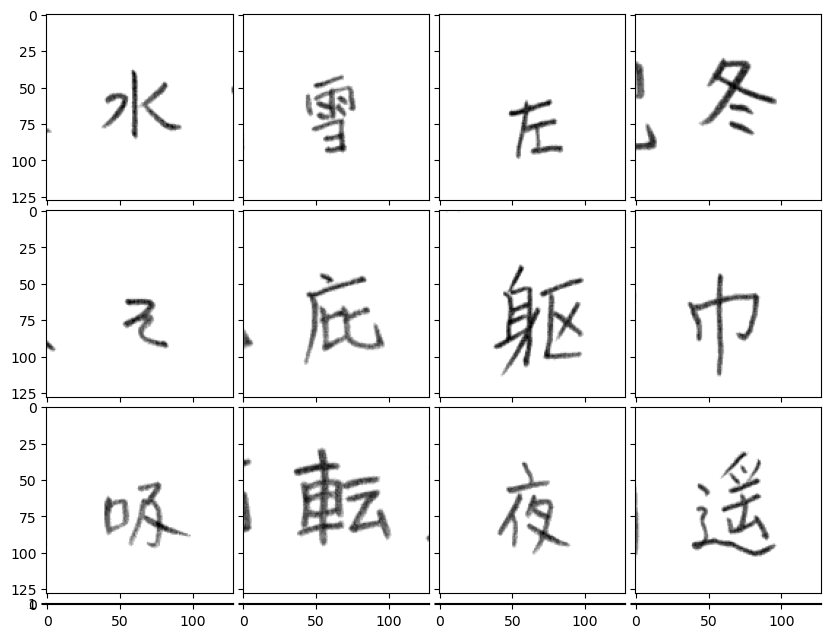

In [20]:
fig = plt.figure(figsize=(10, 13))
grid = ImageGrid(fig, 111, (4, 4), axes_pad=0.1)
for ax, img_id in zip(grid, sample_indicies):
    ax.imshow(images[img_id], 'gray')
    # https://stackoverflow.com/questions/28905938/how-to-use-unicode-symbols-in-matplotlib
    #print(chr(int(codes[img_id], 16)))
    #ax.set_title(str(chr(int(codes[img_id], 16))))
    
plt.show()
fig.savefig('temp.png', pad_inches = 0.0)

In [22]:
if not f_src.closed:
    f_src.close()

In [23]:
# 0x3021 -> 0x4E9C
print(chr(int(0x4E9C)))

亜


In [24]:
hex(int('0x3021',16))

'0x3021'

In [21]:
f"{17:05d}"+'.png'

'00017.png'